In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
!pip install torch==2.8.0+cu128 torchvision==0.23.0+cu128 --index-url https://download.pytorch.org/whl/cu128 --user

Looking in indexes: https://download.pytorch.org/whl/cu128



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4070


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from os.path import join
import glob
import json

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_seg_maps_train = []

with open('preprocessed_masks/train_list.json', 'r') as f:
    preprocessed_train_masks = json.load(f)

with open('preprocessed_masks/test_list.json', 'r') as f:
    preprocessed_test_masks = json.load(f)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class UltraFastSegmentationDataset(Dataset):
    def __init__(self, image_files, preprocessed_mask_files, image_size=(300, 300)):
        self.image_files = image_files
        self.preprocessed_mask_files = preprocessed_mask_files
        self.image_size = image_size
        self.num_classes = 19

        # Transform для изображений (маски уже с resize)
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)
    
    def get_num_classes(self):
        return self.num_classes

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        
        # Загружаем ПРЕДОБРАБОТАННУЮ маску (уже с resize)
        mask_path = self.preprocessed_mask_files[idx]
        mask_transformed = np.load(mask_path)
        
        # Преобразуем изображение
        img_transformed = self.image_transform(img)
        
        # Конвертируем маску в тензор
        mask_transformed = torch.from_numpy(mask_transformed).long()
        
        return img_transformed, mask_transformed
    
# Collate function для DataLoader
def collate_fn(batch):
    images = []
    masks = []
    
    for img, mask in batch:
        images.append(img)
        masks.append(mask)
    
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    
    return images, masks

# Ресайз до 256 на 256

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

class UltraFastSegmentationDataset(Dataset):
    def __init__(self, image_files, preprocessed_mask_files, image_size=(256, 256)):
        self.image_files = image_files
        self.preprocessed_mask_files = preprocessed_mask_files
        self.image_size = image_size
        self.num_classes = 19

        # Transform для изображений
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        # Transform для масок
        self.mask_transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.image_files)

    def get_num_classes(self):
        return self.num_classes

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")

        # Загружаем предобработанную маску (numpy)
        mask_path = self.preprocessed_mask_files[idx]
        mask = np.load(mask_path)

        # Преобразуем изображение
        img_transformed = self.image_transform(img)

        # Ресайзим маску через PIL (чтобы соответствовала image_size)
        mask = Image.fromarray(mask.astype(np.uint8))
        mask = self.mask_transform(mask)
        mask = torch.from_numpy(np.array(mask)).long()

        return img_transformed, mask

    @staticmethod
    def collate_fn(batch):
        images = torch.stack([x[0] for x in batch], dim=0)
        masks = torch.stack([x[1] for x in batch], dim=0)
        return images, masks


In [8]:
# 2. Создаем быстрые датасеты
train_dataset = UltraFastSegmentationDataset(
    file_names_photo_train, preprocessed_train_masks, (512, 512)
)
test_dataset = UltraFastSegmentationDataset(
    file_names_photo_test, preprocessed_test_masks, (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [18]:
import numpy as np

# Функция для визуализации батча
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        if i >= images.shape[0]:
            break
            
        # Денормализуем изображение
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска
        mask = masks[i].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')
        
        im = axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=train_dataset.get_num_classes()-1)
        axes[i, 1].set_title(f'Mask {i}')
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])
    
    plt.tight_layout()
    plt.show()

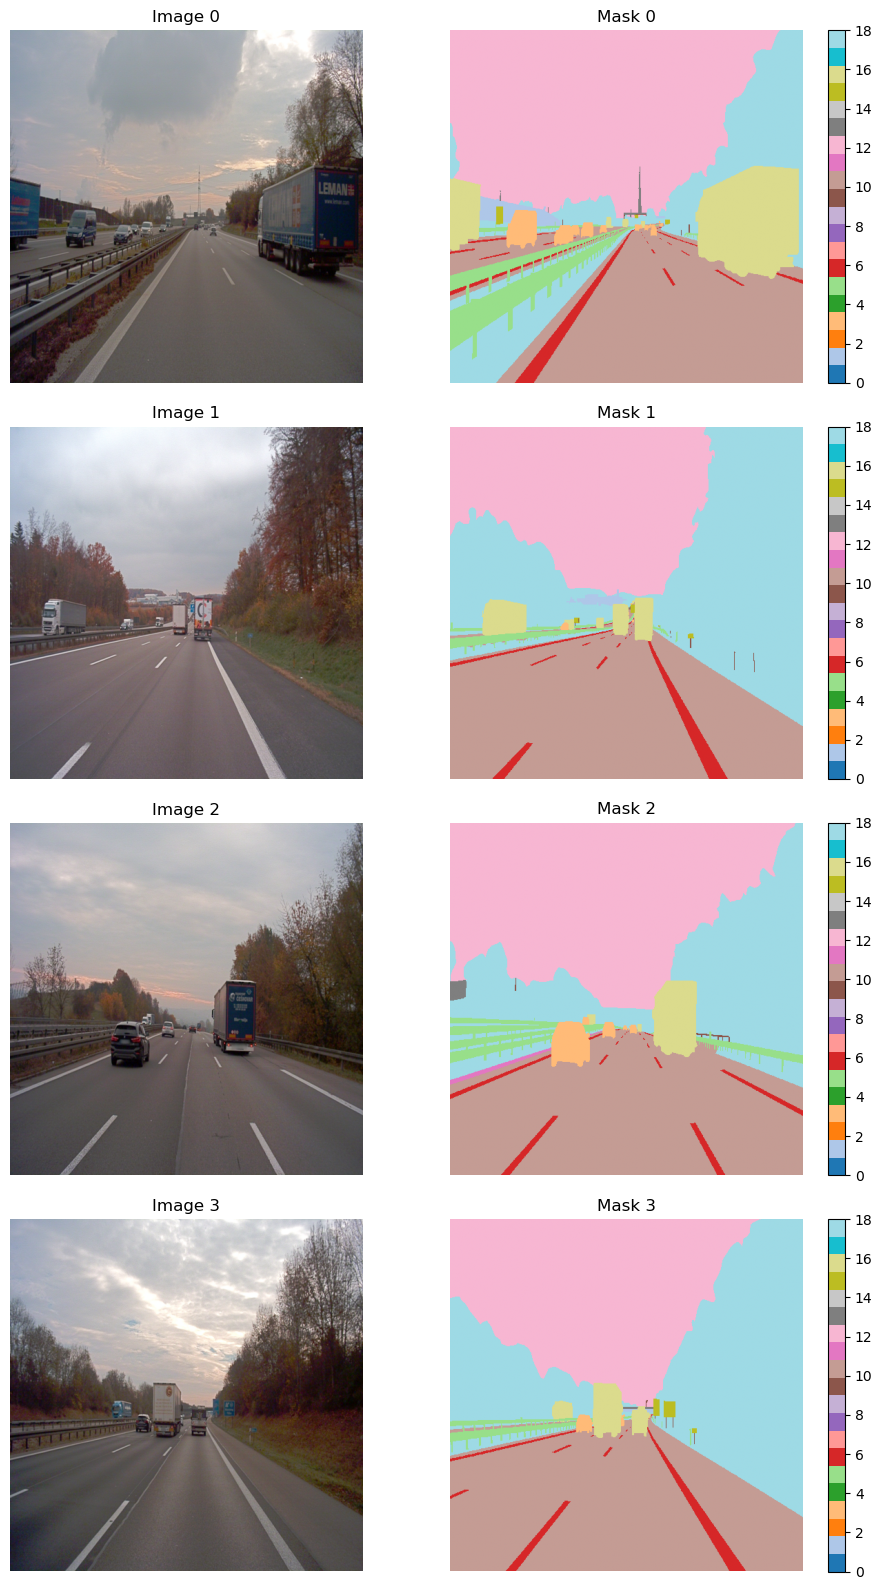

In [9]:
# Использование
for images, masks in train_loader:
    visualize_batch(images, masks)
    break

In [9]:
from mask2former import SimplifiedMask2Former  # Убедитесь, что код в файле mask2former.py

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Создаем модель
num_classes = 19  # Замените на ваше значение train_dataset.get_num_classes()
model = SimplifiedMask2Former(
    num_classes=num_classes,
    backbone='resnet50',
    hidden_dim=128,
    num_queries=50,
    num_heads=4,
    num_layers=4
).to(device)

# Проверяем форматы
dummy_input = torch.randn(4, 3, 512, 512).to(device)
dummy_mask = torch.randint(0, num_classes, (4, 512, 512)).to(device)

print("Input shape:", dummy_input.shape)
print("Mask shape:", dummy_mask.shape)

# Forward pass (тренировка)
output = model(dummy_input, dummy_mask)
print("Loss:", output.item())

# Для инференса
with torch.no_grad():
    prediction = model(dummy_input)
    print("Prediction shape:", prediction.shape)

C:\Users\neUral\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Input shape: torch.Size([4, 3, 512, 512])
Mask shape: torch.Size([4, 512, 512])
Loss: 2.9507901668548584
Prediction shape: torch.Size([4, 19, 512, 512])


In [9]:
class_weights = torch.tensor([6.6759e-02, 7.4535e-04, 5.8502e-02, 1.4638e-03, 4.0718e-01, 9.5851e-03,
        7.2199e-03, 2.6133e-01, 5.4994e-02, 9.6064e-03, 3.4003e-04, 2.7777e-03,
        3.2883e-04, 6.4901e-03, 8.3840e-02, 1.0784e-02, 3.1417e-03, 1.4554e-02,
        3.5410e-04]).to(device)

print(class_weights)

tensor([6.6759e-02, 7.4535e-04, 5.8502e-02, 1.4638e-03, 4.0718e-01, 9.5851e-03,
        7.2199e-03, 2.6133e-01, 5.4994e-02, 9.6064e-03, 3.4003e-04, 2.7777e-03,
        3.2883e-04, 6.4901e-03, 8.3840e-02, 1.0784e-02, 3.1417e-03, 1.4554e-02,
        3.5410e-04], device='cuda:0')


In [10]:
from mask2former import SimplifiedMask2Former  # Убедитесь, что код в файле mask2former.py

# Создаем модель
num_classes = 19  # Замените на ваше значение train_dataset.get_num_classes()
model = SimplifiedMask2Former(
    num_classes=num_classes,
    backbone='resnet50',
    hidden_dim=128,
    num_queries=50,
    num_heads=4,
    num_layers=4,
    class_weights = class_weights
).to(device)

C:\Users\neUral\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Оптимизатор
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Планировщик (опционально)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Уменьшает lr в 10 раз каждые 10 эпох

In [13]:
checkpoint = torch.load('.\\models\\pitstop_mask2former_rn50.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# После загрузки оптимизатора
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-5  # Новое значение learning rate для fine-tuning

In [14]:
num_epochs = 40
history_train = []
history_val = []

In [15]:
from tqdm import tqdm
import numpy as np

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        loss = model(images, masks)  # Возвращает скалярный лосс
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)  # суммируем loss по батчам

    avg_train_loss = train_loss / len(train_loader.dataset)
    history_train.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1} Val", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            loss = model(images, masks)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    history_val.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()


Epoch [1/40] Train Loss: 0.3236 Val Loss: 0.4141 LR: 3.00e-05


Epoch [2/40] Train Loss: 0.2711 Val Loss: 0.4108 LR: 3.00e-05


KeyboardInterrupt: 

In [25]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val_loss,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_mask2former_rn50.pth')

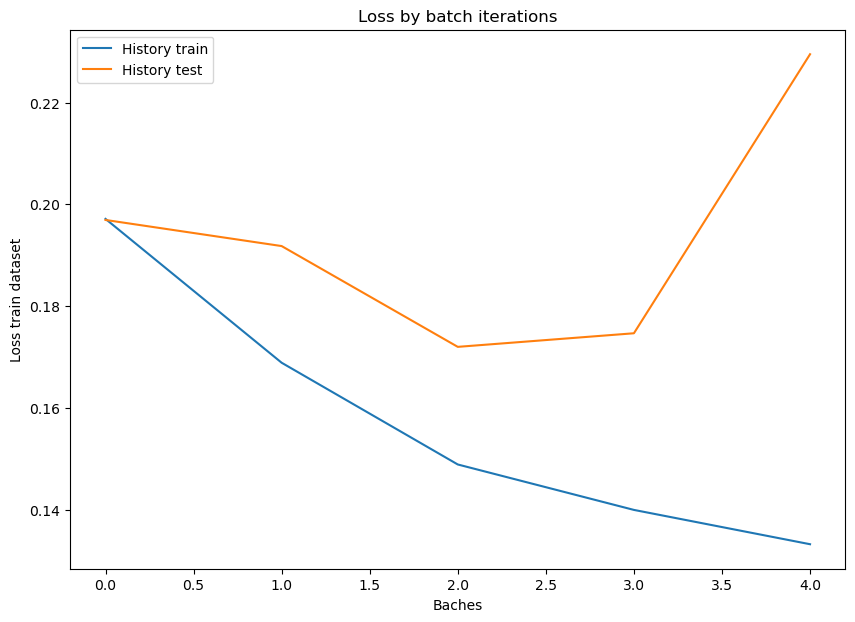

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(history_train, label = 'History train')
plt.plot(history_val, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Loss train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [19]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\special\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train_vis = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train_vis.append(file_name_image)

start = 0
end = 0

for i in range(len(file_names_photo_train)):
    if file_names_photo_train[i][37:] == file_names_photo_train_vis[0][39:]:
        start = i
    if file_names_photo_train[i][37:] == file_names_photo_train_vis[-1][39:]:
        end = i

# 2. Создаем быстрые датасеты
special_dataset = UltraFastSegmentationDataset(
    file_names_photo_train_vis, preprocessed_train_masks[start:end], (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
special_loader = DataLoader(special_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

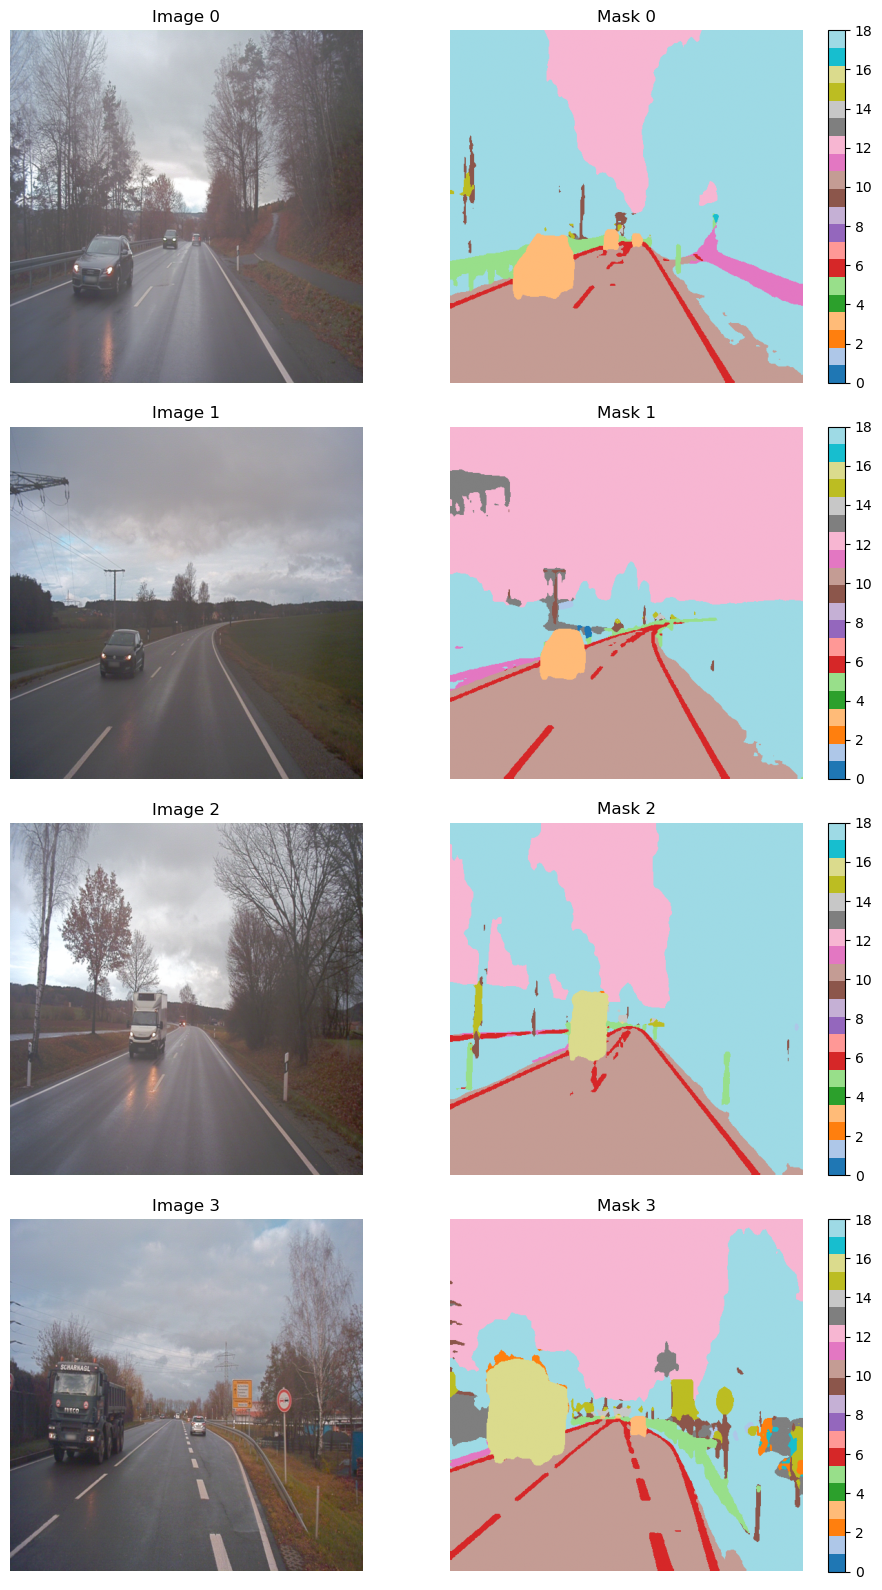

In [20]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)

        predictions = torch.argmax(outputs, dim=1)

        visualize_batch(images.cpu(), predictions.cpu())

        break

In [21]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

class SegmentationMetrics:
    def __init__(self, num_classes=19, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.num_classes = num_classes
        self.device = device
        
    def _get_confusion_matrix(self, pred, target):
        """Вычисляет матрицу confusion для батча"""
        pred = pred.flatten()
        target = target.flatten()
        mask = (target >= 0) & (target < self.num_classes)
        return confusion_matrix(
            target[mask].cpu().numpy(), 
            pred[mask].cpu().numpy(), 
            labels=list(range(self.num_classes))
        )
    
    def compute_iou(self, cm):
        """Вычисляет IoU из матрицы confusion"""
        intersection = np.diag(cm)
        union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
        iou = intersection / (union + 1e-10)
        return iou
    
    def compute_precision_recall_f1(self, cm):
        """Вычисляет Precision, Recall и F1-score"""
        tp = np.diag(cm)
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        return precision, recall, f1
    
    def compute_metrics(self, predictions, targets):
        """
        Вычисляет все метрики для батча предсказаний
        
        Args:
            predictions: torch.Tensor [batch_size, H, W] с предсказанными классами
            targets: torch.Tensor [batch_size, H, W] с истинными метками
        
        Returns:
            dict: Словарь со всеми вычисленными метриками
        """
        # Проверяем размерности
        assert predictions.shape == targets.shape, "Размеры predictions и targets должны совпадать"
        
        # Инициализируем общую матрицу confusion
        total_cm = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)
        
        # Обрабатываем каждый элемент батча
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = targets[i]
            cm = self._get_confusion_matrix(pred, target)
            total_cm += cm
        
        # Вычисляем все метрики
        iou_per_class = self.compute_iou(total_cm)
        precision_per_class, recall_per_class, f1_per_class = self.compute_precision_recall_f1(total_cm)
        
        # Вычисляем средние значения
        miou = np.nanmean(iou_per_class)
        mean_precision = np.nanmean(precision_per_class)
        mean_recall = np.nanmean(recall_per_class)
        mean_f1 = np.nanmean(f1_per_class)
        
        # Вычисляем Pixel Accuracy
        total_pixels = total_cm.sum()
        correct_pixels = np.diag(total_cm).sum()
        pixel_accuracy = correct_pixels / total_pixels
        
        # Mean Pixel Accuracy
        mean_pixel_accuracy = np.nanmean(np.diag(total_cm) / (total_cm.sum(axis=1) + 1e-10))
        
        return {
            'miou': miou,
            'iou_per_class': iou_per_class,
            'pixel_accuracy': pixel_accuracy,
            'mean_pixel_accuracy': mean_pixel_accuracy,
            'mean_precision': mean_precision,
            'mean_recall': mean_recall,
            'mean_f1': mean_f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'confusion_matrix': total_cm
        }

In [22]:
import torch.nn.functional as F

# Инициализация
metrics_calculator = SegmentationMetrics(num_classes=19)

# Предположим, у нас есть модель и данные
# model = YourSegmentationModel()
# dataloader = YourDataLoader()

all_metrics = []

for batch_idx, (images, targets) in enumerate(test_loader):
    with torch.no_grad():
        images = images.to(device)
        # Получаем предсказания (вероятности)
        outputs = model(images)
        
        # Преобразуем в классы [batch_size, H, W]
        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        
        # Вычисляем метрики для батча
        metrics = metrics_calculator.compute_metrics(predictions.cpu(), targets)
        all_metrics.append(metrics)
        
        # Можно выводить промежуточные результаты
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}: mIoU = {metrics['miou']:.4f}, PA = {metrics['pixel_accuracy']:.4f}")

# Усредняем метрики по всем батчам
final_metrics = {
    'miou': np.mean([m['miou'] for m in all_metrics]),
    'pixel_accuracy': np.mean([m['pixel_accuracy'] for m in all_metrics]),
    'mean_pixel_accuracy': np.mean([m['mean_pixel_accuracy'] for m in all_metrics]),
    'mean_f1': np.mean([m['mean_f1'] for m in all_metrics])
}

print("\nFinal Metrics:")
print(f"Mean IoU: {final_metrics['miou']:.4f}")
print(f"Pixel Accuracy: {final_metrics['pixel_accuracy']:.4f}")
print(f"Mean Pixel Accuracy: {final_metrics['mean_pixel_accuracy']:.4f}")
print(f"Mean F1-Score: {final_metrics['mean_f1']:.4f}")

Batch 0: mIoU = 0.3777, PA = 0.9384
Batch 10: mIoU = 0.3679, PA = 0.9143
Batch 20: mIoU = 0.3989, PA = 0.9268
Batch 30: mIoU = 0.3604, PA = 0.9152
Batch 40: mIoU = 0.3125, PA = 0.9707
Batch 50: mIoU = 0.4054, PA = 0.9145
Batch 60: mIoU = 0.3723, PA = 0.9144

Final Metrics:
Mean IoU: 0.3452
Pixel Accuracy: 0.9286
Mean Pixel Accuracy: 0.4777
Mean F1-Score: 0.4047


In [23]:
final_metrics = {
    'miou': np.mean([m['miou'] for m in all_metrics]),
    'pixel_accuracy': np.mean([m['pixel_accuracy'] for m in all_metrics]),
    'mean_pixel_accuracy': np.mean([m['mean_pixel_accuracy'] for m in all_metrics]),
    'mean_f1': np.mean([m['mean_f1'] for m in all_metrics])
}

print("\nFinal Metrics:")
print(f"Mean IoU: {final_metrics['miou']:.4f}")
print(f"Pixel Accuracy: {final_metrics['pixel_accuracy']:.4f}")
print(f"Mean Pixel Accuracy: {final_metrics['mean_pixel_accuracy']:.4f}")
print(f"Mean F1-Score: {final_metrics['mean_f1']:.4f}")


Final Metrics:
Mean IoU: 0.4646
Pixel Accuracy: 0.9468
Mean Pixel Accuracy: 0.5177
Mean F1-Score: 0.5354
